In [1]:
# Importing Libraries

import numpy as np
import pandas as pd


import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
#------ Additional Lib
import neattext as nt
import neattext.functions as nfx

from sklearn.feature_extraction.text import TfidfVectorizer   # Turning textual data into numeric for computation
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder               # For encoding categorical target attr
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn import svm   # Baseline

# ------- Validation metrics
from sklearn.metrics import accuracy_score    
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import hamming_loss                  



## Data Preprocessing

In [2]:
nltk.download('stopwords')
# stop_words

[nltk_data] Downloading package stopwords to C:\Users\Computer
[nltk_data]     Point\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
print(stopwords.words('English'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [4]:
df = pd.read_csv('data_train.csv', header=None, names=["country", "sku_id", "title", "category_lvl1","category_lvl2",
                                                       "category_lvl3", "description", "price", "type"])   #No titles
df.head()

,country,sku_id,title,category_lvl1,category_lvl2,category_lvl3,description,price,type
0,my,AD674FAASTLXANMY,Adana Gallery Suri Square Hijab – Light Pink,Fashion,Women,Muslim Wear,<ul><li>Material : Non sheer shimmer chiffon</...,49.00,local
1,my,AE068HBAA3RPRDANMY,Cuba Heartbreaker Eau De Parfum Spray 100ml/3.3oz,Health & Beauty,Bath & Body,Hand & Foot Care,Formulated with oil-free hydrating botanicals/...,128.00,international
2,my,AN680ELAA9VN57ANMY,Andoer 150cm Cellphone Smartphone Mini Dual-He...,"TV, Audio / Video, Gaming & Wearables",Audio,Live Sound & Stage,<ul> <li>150cm mini microphone compatible for ...,25.07,international
3,my,AN957HBAAAHDF4ANMY,ANMYNA Complaint Silky Set 柔顺洗发配套 (Shampoo 520...,Health & Beauty,Hair Care,Shampoos & Conditioners,<ul> <li>ANMYNA Complaint Silky Set (Shampoo 5...,118.00,local
4,my,AR511HBAXNWAANMY,Argital Argiltubo Green Clay For Face and Body...,Health & Beauty,Men's Care,Body and Skin Care,<ul> <li>100% Authentic</li> <li>Rrefresh and ...,114.80,international


### Data Stats

In [5]:
df.shape  # 9 features

(36283, 9)

In [6]:
# Finding the percentage of missing values in dataset
missing_val = df.isnull().sum()
print(missing_val)
total_cells = np.product(df.shape)
missing_percent = (missing_val.sum()/total_cells) *100
print(f'\nThe missing data percent is: {missing_percent}')

country             0
sku_id              0
title               0
category_lvl1       0
category_lvl2       0
category_lvl3    2135
description        33
price               0
type              277
dtype: int64

The missing data percent is: 0.7487436724269401


In [7]:
# Using Imputation to handle missing values, if this technique doesnt work with model training then we will opt for deletion of null values
df = df.fillna("")
# Need to replace it with knn classifier value prediction (Optimal solution)

In [8]:
arr1 = set(df['category_lvl1'].unique())
arr2 = set(df['category_lvl2'].unique())
arr3 = set(df['category_lvl3'].unique())

common = arr3.intersection(arr2)
common
# nothing common in all three

{'Accessories', 'Gadgets', 'Gaming', 'Men', 'Point & Shoot', 'Women'}

In [9]:
# 3 labels in dataset: category1, category2 and category3
print(df['category_lvl1'].nunique()) # 9 distinct classes in category 1
print(df['category_lvl2'].nunique()) # 57 distinct classes in category 1
print(df['category_lvl3'].nunique()) # 184 distinct classes in category 1

9
57
185


In [10]:
df.dtypes

country           object
sku_id            object
title             object
category_lvl1     object
category_lvl2     object
category_lvl3     object
description       object
price            float64
type              object
dtype: object

In [11]:
# Most occuring category labels
print(df['category_lvl1'].mode())
print(df['category_lvl2'].mode())
print(df['category_lvl3'].mode())

0    Mobiles & Tablets
Name: category_lvl1, dtype: object
0    Accessories
Name: category_lvl2, dtype: object
0    Phone Cases
Name: category_lvl3, dtype: object


### Data visualization

Text(0.5, 0, 'Categories')

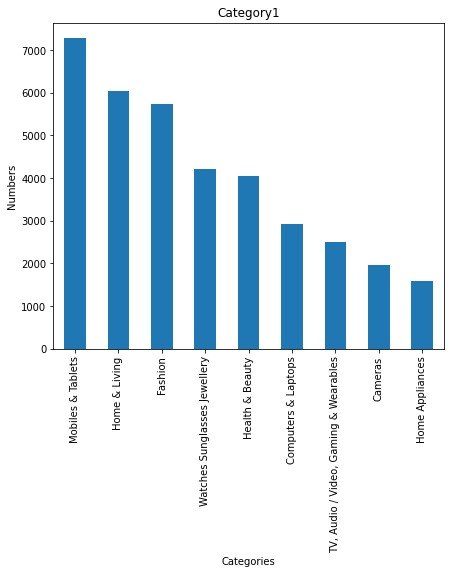

In [12]:
ax1 = df['category_lvl1'].value_counts().plot(kind = 'bar', title='Category1', figsize=(7,6))
ax1.set_ylabel("Numbers")
ax1.set_xlabel("Categories")

Text(0, 0.5, 'Categories')

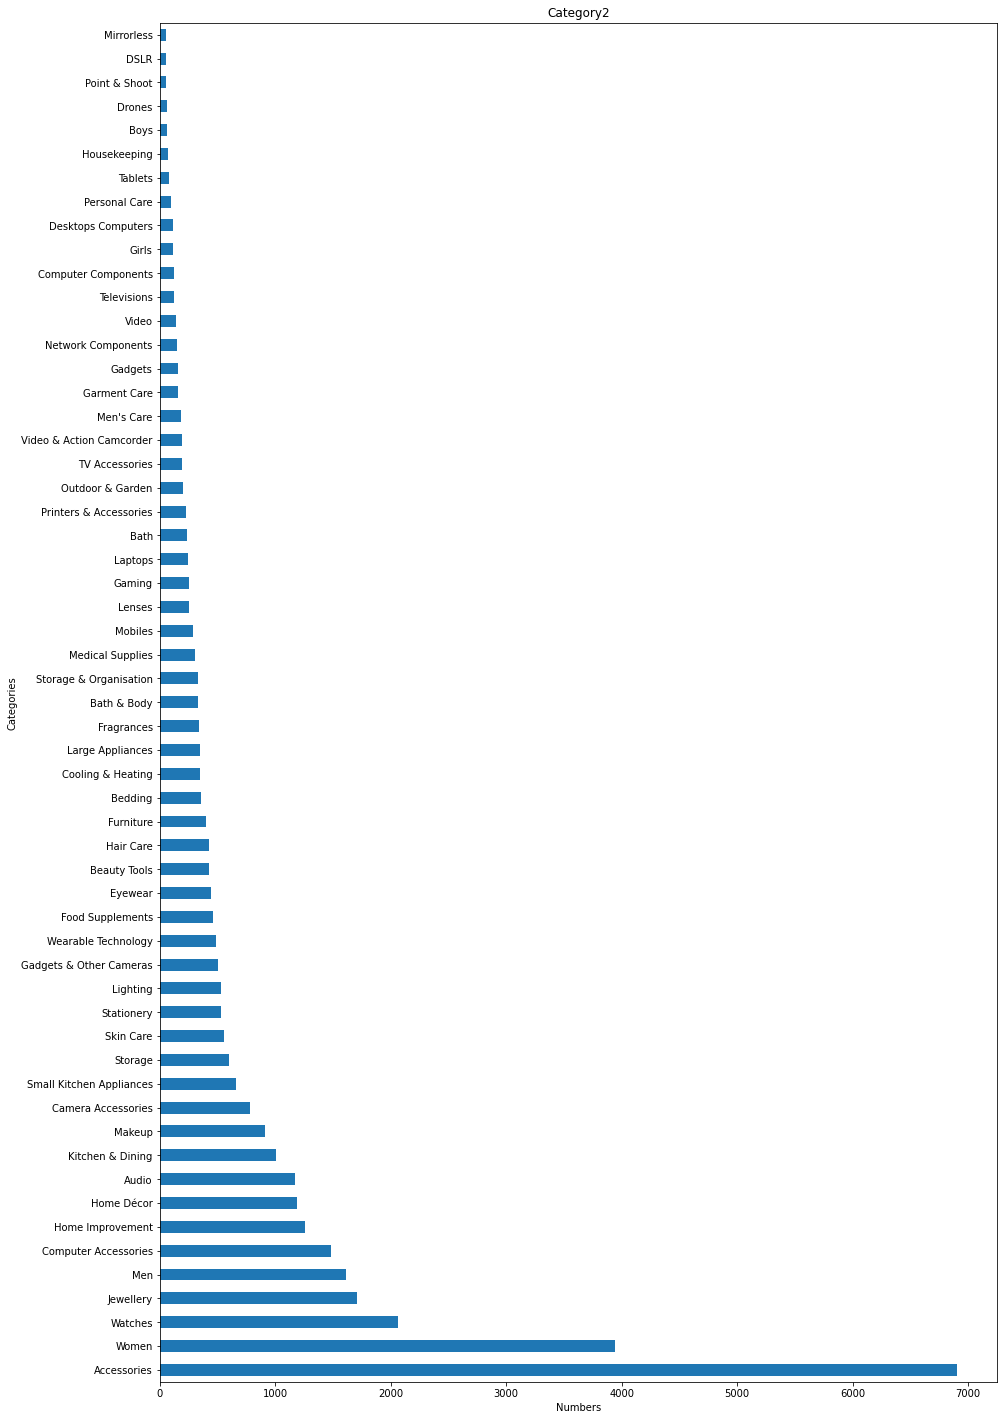

In [13]:
ax2=df['category_lvl2'].value_counts().plot(kind = 'barh', title='Category2', figsize=(15,25))
ax2.set_xlabel("Numbers")
ax2.set_ylabel("Categories")

Text(0, 0.5, 'Categories')

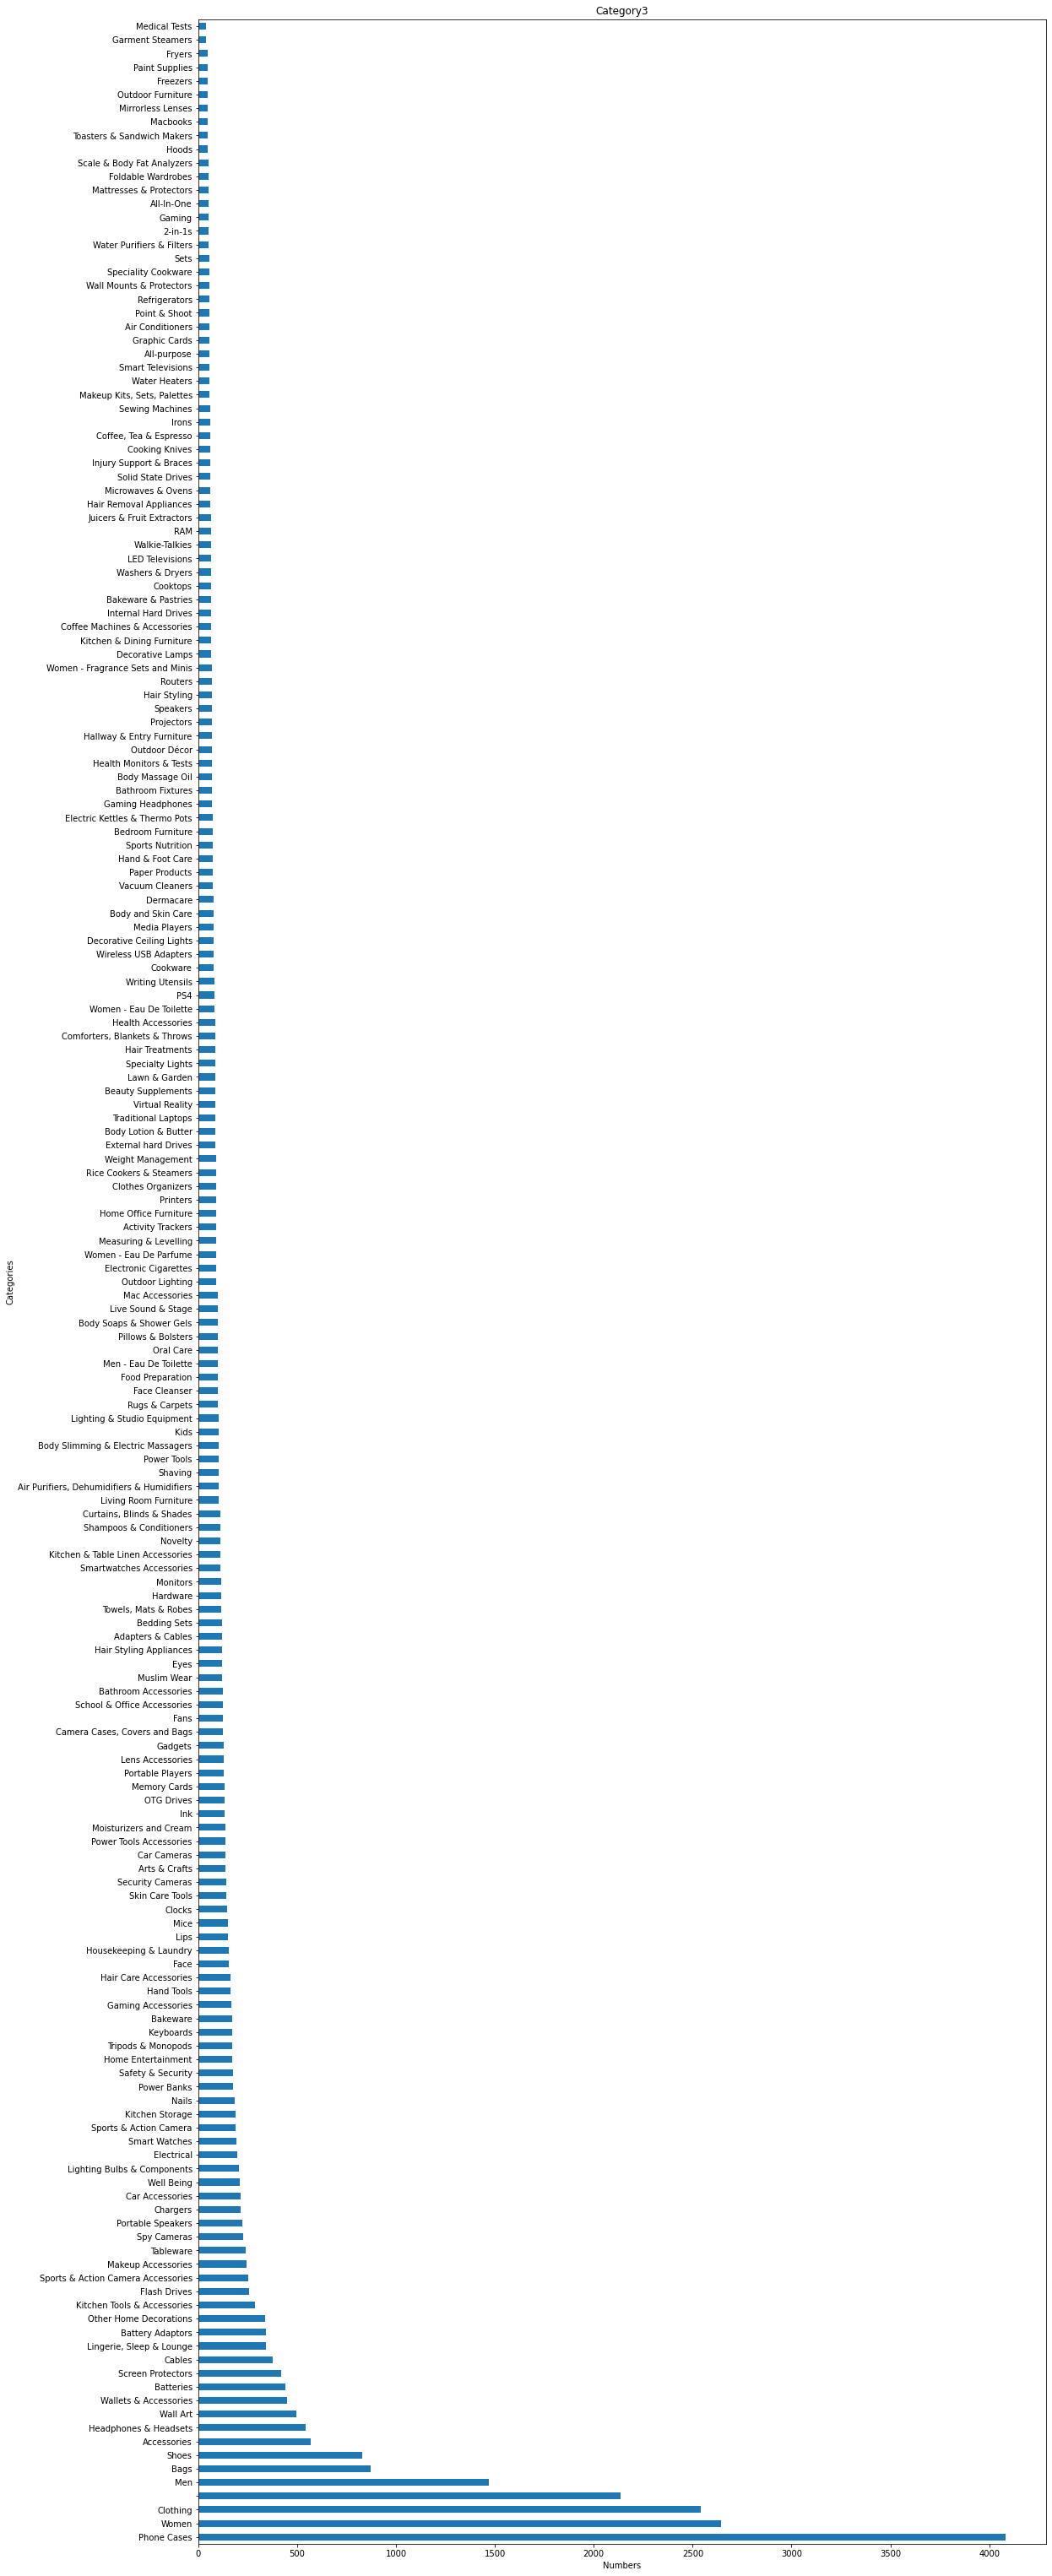

In [14]:
ax3=df['category_lvl3'].value_counts().plot(kind = 'barh', title='Category3', figsize=(18,55))
ax3.set_xlabel("Numbers")
ax3.set_ylabel("Categories")

### Text Preprocessing

In [15]:
# Merging title and description column to make predictions (Approach 01)

df['combined'] = df['title']+" "+df['description']
df['combined']

0        Adana Gallery Suri Square Hijab – Light Pink <...
1        Cuba Heartbreaker Eau De Parfum Spray 100ml/3....
2        Andoer 150cm Cellphone Smartphone Mini Dual-He...
3        ANMYNA Complaint Silky Set 柔顺洗发配套 (Shampoo 520...
4        Argital Argiltubo Green Clay For Face and Body...
                               ...                        
36278    SADES K10 LED Backlit Wired USB Mechanical Gam...
36279    SONA 20L Electric Oven SEO 2220 <ul> <li>&nbsp...
36280    OP1001 Portable Wireless Bluetooth 2.1 Speaker...
36281    Woot-Woot TicTacToe Pillow Case (White) <ul> <...
36282    New Smart Wristband D21 Smart Bracelet Heart R...
Name: combined, Length: 36283, dtype: object

In [16]:
# Cleaning 'combined' attribute to remove encodings, html tags etc 
ps = PorterStemmer()

# CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def stemming(content):
    # Using str(content) because there are some float values in combined
    stemmed_content = re.sub('[^a-zA-Z]',' ',str(content))   # Dropping all encodings, numbers etc
#     stemmed_content = re.sub(CLEANR, '',stemmed_content)
    stemmed_content = stemmed_content.lower()
    stemmed_content = stemmed_content.split()
    stemmed_content = [ps.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
    stemmed_content = ' '.join(stemmed_content)
    return stemmed_content


df['combined'] = df['combined'].apply(stemming)
df['combined']

0        adana galleri suri squar hijab light pink ul l...
1        cuba heartbreak eau de parfum spray ml oz form...
2        andoer cm cellphon smartphon mini dual head om...
3        anmyna complaint silki set shampoo ml conditio...
4        argit argiltubo green clay face bodi ml ul li ...
                               ...                        
36278    sade k led backlit wire usb mechan game keyboa...
36279    sona l electr oven seo ul li nbsp year warrant...
36280    op portabl wireless bluetooth speaker hand fre...
36281    woot woot tictacto pillow case white ul li cot...
36282    new smart wristband smart bracelet heart rate ...
Name: combined, Length: 36283, dtype: object

In [17]:
# Scan for noise
df['title'].apply(lambda x:nt.TextFrame(x).noise_scan())

0        {'text_noise': 0, 'text_length': 44, 'noise_co...
1        {'text_noise': 4.081632653061225, 'text_length...
2        {'text_noise': 2.898550724637681, 'text_length...
3        {'text_noise': 4.3478260869565215, 'text_lengt...
4        {'text_noise': 3.8461538461538463, 'text_lengt...
                               ...                        
36278    {'text_noise': 5.05050505050505, 'text_length'...
36279    {'text_noise': 0, 'text_length': 31, 'noise_co...
36280    {'text_noise': 5.839416058394161, 'text_length...
36281    {'text_noise': 7.6923076923076925, 'text_lengt...
36282    {'text_noise': 1.5037593984962405, 'text_lengt...
Name: title, Length: 36283, dtype: object

In [18]:
# Build Features
X = df['combined']
Y1 = df['category_lvl1'].values
X.shape

(36283,)

###  Feature Engineering

In [19]:
# Build Features ---> Feature Engineering

vectorizer = TfidfVectorizer()
vectorizer.fit(X)
X = vectorizer.transform(X)
print(X)
print(X.shape)

  (0, 28926)	0.07225450905676557
  (0, 26979)	0.37659622945779203
  (0, 26088)	0.1998319065525262
  (0, 25138)	0.09569170611896965
  (0, 24743)	0.274909852967693
  (0, 24698)	0.24936820421274508
  (0, 21066)	0.14762071827644638
  (0, 19170)	0.15193068032445747
  (0, 16928)	0.07800926343011164
  (0, 15872)	0.12477040286740318
  (0, 15807)	0.2166021835962534
  (0, 13588)	0.2635334721682102
  (0, 12714)	0.28221876200452894
  (0, 11068)	0.31718455107540455
  (0, 8885)	0.20669214994280302
  (0, 6559)	0.16898596478813072
  (0, 6539)	0.21996883037486475
  (0, 4947)	0.20363757921662629
  (0, 274)	0.37659622945779203
  (1, 27663)	0.1629852900420418
  (1, 26026)	0.18367699107979166
  (1, 25598)	0.11213832261211402
  (1, 25471)	0.14499581148205976
  (1, 25184)	0.12733674466390438
  (1, 23203)	0.20555964568802804
  :	:
  (36282, 12163)	0.057806455567404394
  (36282, 11832)	0.05824639332538744
  (36282, 11322)	0.12069390547092858
  (36282, 10946)	0.05221275370600469
  (36282, 10134)	0.0489039124928

In [20]:
Y1 = pd.get_dummies(Y1) # one hot encoding
print('Shape of label tensor:', Y1.shape)

Y1
# train_Y_c2 = pd.get_dummies(tCol_df['c2']).values # one hot encoding
# print('Shape of label tensor:', train_Y_c2.shape)

# train_Y_c3 = pd.get_dummies(tCol_df['c3']).values # one hot encoding
# print('Shape of label tensor:', train_Y_c3.shape)

Shape of label tensor: (36283, 9)


,Cameras,Computers & Laptops,Fashion,Health & Beauty,Home & Living,Home Appliances,Mobiles & Tablets,"TV, Audio / Video, Gaming & Wearables",Watches Sunglasses Jewellery
0,0,0,1,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
36278,0,1,0,0,0,0,0,0,0
36279,0,0,0,0,0,1,0,0,0
36280,0,1,0,0,0,0,0,0,0
36281,0,0,0,0,1,0,0,0,0


In [21]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y1, test_size = 0.2, stratify = Y1, random_state = 42)  


### Model Training

In [ ]:
model = DecisionTreeClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

In [ ]:
# Compute accuracy
score = accuracy_score(Y_test, predictions)
print(f'Accuracy: {score}')
# Compute hamming loss
loss = hamming_loss(Y_test, predictions)
print(f'Loss: {loss}')
# Compute cohens kappa
# kappa = cohen_kappa_score(Y_test, predictions)
# print(f"Cohens Kappa: {kappa}")

# Also try to compute it with categorical Y

In [ ]:
confusion_matrix(y_true, y_pred)